In [2]:
from io import BytesIO
import os
import boto3
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms

## Construct Customized Torch Dataset

In [9]:
from data.grasp_dataset import load_np_s3

In [20]:
class RGBD_R7_R9_Dataset(torch.utils.data.Dataset):
    def __init__(self, s3_path: str, split: str, resize: tuple = (224, 224)):
        self.s3_path = s3_path
        table = pd.read_parquet(self.s3_path)
        self.split = split
        self.table = table[table["split"] == self.split]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resize_transform = transforms.Resize(resize)
    
    def __len__(self):
        return len(self.table)

    def __getitem__(self, idx):
        s3_links = self.table.iloc[idx]

        # load the data from s3
        s3_client = boto3.client('s3')
        datum = {
            "image": torch.from_numpy(load_np_s3(s3_links["image"], s3_client)), # (3, H_full, W_full)
            "intrinsics": torch.from_numpy(load_np_s3(s3_links["reference_camera_intrinsics"], s3_client)), # (3, 3)
            "obj_depth_map": self.resize_transform(torch.from_numpy(load_np_s3(s3_links["obj_depth_map"], s3_client)).unsqueeze(0)), # (1, H_resize, W_resize)
            "obj_rgb": self.resize_transform(torch.from_numpy(load_np_s3(s3_links["obj_rgb"], s3_client))), # (3, H_resize, W_resize)
            "top_grasp_r7": torch.from_numpy(load_np_s3(s3_links["top_grasp_r7"], s3_client)), # (7,)
            "top_grasp_r9": torch.from_numpy(load_np_s3(s3_links["top_grasp_r9"], s3_client)), # (9,)
        }

        return datum

## Create Dataloader

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
dataset = RGBD_R7_R9_Dataset(s3_path="s3://covariant-datasets-prod/dp_finger_grasp_dataset_small_test_2025_07_24_06_00", split="train")
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
)

## Load and Visualize Data

In [15]:
from viz.grasp_viz import draw_top_grasp_point
from PIL import Image, ImageDraw

In [24]:
# Load data and check the tensor shape
for i, batch in enumerate(dataloader):
    nimage = batch['image'].to(device)
    nobj_depth = batch['obj_depth_map'].to(device)
    nobj_rgb = batch['obj_rgb'].to(device)
    ntop_grasp_r7 = batch['top_grasp_r7'].to(device)
    ntop_grasp_r9 = batch['top_grasp_r9'].to(device)
    nintrinsics = batch['intrinsics'].to(device)

    print(f"------Batch Idx {i}------")
    print("nimage shape:", nimage.shape)
    print("nobj_rgb shape:", nobj_rgb.shape)
    print("nobj_depth shape:", nobj_depth.shape)
    print("ntop_grasp_r7 shape:", ntop_grasp_r7.shape)
    print("ntop_grasp_r9 shape:", ntop_grasp_r9.shape)
    print("nintrinsics:", nintrinsics.shape)

    ######
    # Model training follows
    ######

------Batch Idx 0------
nimage shape: torch.Size([32, 3, 576, 1024])
nobj_rgb shape: torch.Size([32, 3, 224, 224])
nobj_depth shape: torch.Size([32, 1, 224, 224])
ntop_grasp_r7 shape: torch.Size([32, 7])
ntop_grasp_r9 shape: torch.Size([32, 9])
nintrinsics: torch.Size([32, 3, 3])
------Batch Idx 1------
nimage shape: torch.Size([32, 3, 576, 1024])
nobj_rgb shape: torch.Size([32, 3, 224, 224])
nobj_depth shape: torch.Size([32, 1, 224, 224])
ntop_grasp_r7 shape: torch.Size([32, 7])
ntop_grasp_r9 shape: torch.Size([32, 9])
nintrinsics: torch.Size([32, 3, 3])
------Batch Idx 2------
nimage shape: torch.Size([32, 3, 576, 1024])
nobj_rgb shape: torch.Size([32, 3, 224, 224])
nobj_depth shape: torch.Size([32, 1, 224, 224])
ntop_grasp_r7 shape: torch.Size([32, 7])
ntop_grasp_r9 shape: torch.Size([32, 9])
nintrinsics: torch.Size([32, 3, 3])
------Batch Idx 3------
nimage shape: torch.Size([32, 3, 576, 1024])
nobj_rgb shape: torch.Size([32, 3, 224, 224])
nobj_depth shape: torch.Size([32, 1, 224, 

In [26]:
sample_image = nimage[0]
sample_obj_depth = nobj_depth[0]
sample_obj_rgb = nobj_rgb[0]
sample_grasp_r7 = ntop_grasp_r7[0]
sample_grasp_r9 = ntop_grasp_r9[0]
sample_intrinsics = nintrinsics[0]

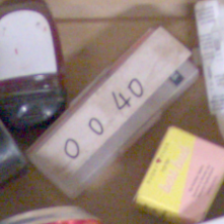

In [27]:
# The cropped RGB image
obj_rgb_255 = (255*sample_obj_rgb.cpu().numpy().transpose(1,2,0)).astype(np.uint8)
img = Image.fromarray(obj_rgb_255)
img

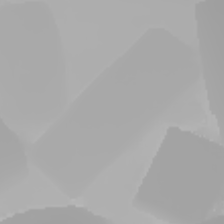

In [28]:
# The cropped depth image
obj_depth_255 = (255*sample_obj_depth.squeeze(0).cpu().numpy()).astype(np.uint8)
img = Image.fromarray(obj_depth_255)
img

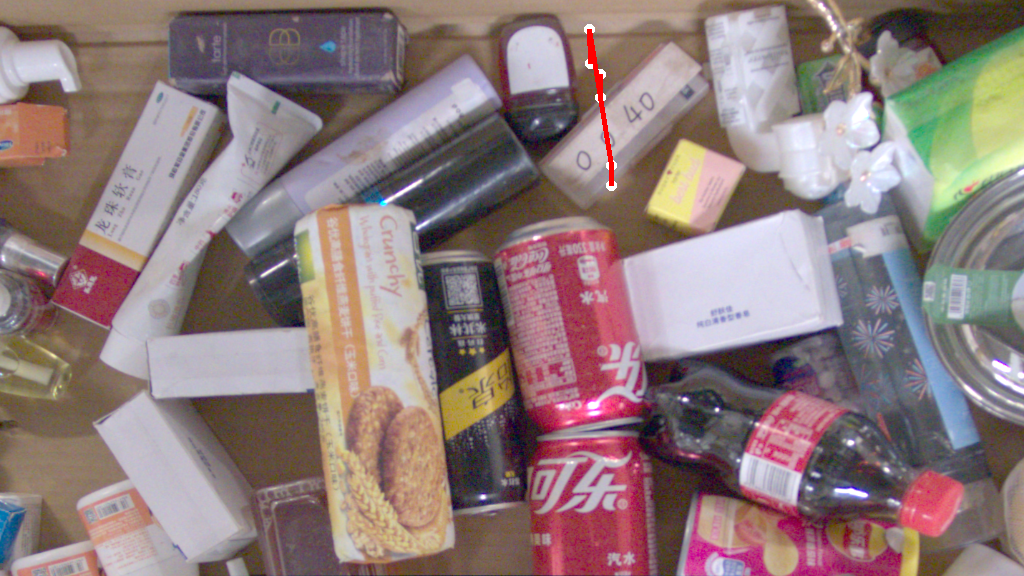

In [29]:
# The R^7 grasp point
draw_top_grasp_point(sample_grasp_r7, sample_image, sample_intrinsics)

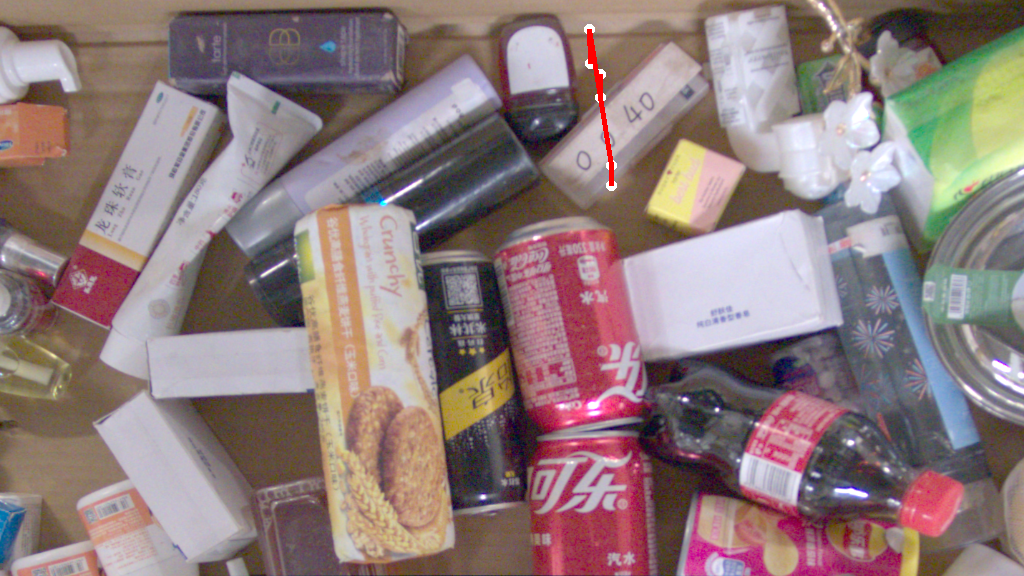

In [30]:
# The R^9 grasp point
draw_top_grasp_point(sample_grasp_r9, sample_image, sample_intrinsics)